In [1]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

In [2]:
# Read Json
raw_data = pd.read_json('./realties.json', lines=True)
df = pd.read_json('./realties.json', lines=False)
df_src = json_normalize(data=df['_source'])

del raw_data
del df

In [3]:
## Select columns by follow Data Sprints Doc ##
null_col = df_src.columns[df_src.isna().sum() > 100000]
df_selected = df_src.drop(null_col, axis=1)

del null_col
del df_src

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Value Distribution - Before Cut Outlier')

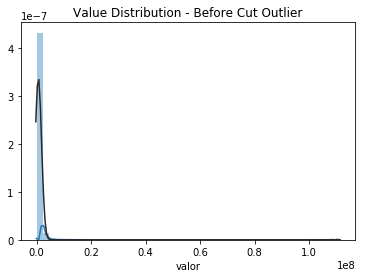

In [4]:
## Plot Value Distribution
sns.distplot(df_selected['valor'].dropna(), fit=norm).set_title("Value Distribution - Before Cut Outlier")

# Wrangling

In [5]:
## Translate Columns Name ##
df_selected.rename(columns={"anunciante.id": "advertiser.id", \
                            "anunciante.nome": "advertiser.name", \
                            "bairro.id": "neighborhood.id", \
                            "bairro.nome": "neighborhood.name", \
                            "banheiro": "bathroom", \
                            "cidade.full_name": "city.full_name", \
                            "cidade.short_name": "city.short_name", \
                            "cidade_uf": "city_uf", \
                            "codigo": "code", \
                            "condominio": "condominium", \
                            "data_inclusao": "date_inclusion", \
                            "descricao": "description", \
                            "endereco": "address", \
                            "tipo_negocio": "business_type", \
                            "garagem": "garage", \
                            "lista_fotos": "photolist", \
                            "opcionais": "optional", \
                            "quarto": "bedroom", \
                            "tipo_imovel": "motion_type", \
                            "valor": "value", \
                            "zoneamento.id": "zoning.id", \
                            "zoneamento.nome": "zoning.name", \
                            "zoneamento.sigla": "zoning.initials", \
                            "finalidade": "goal"
                           }, inplace=True)

In [9]:
df_selected['motion_type'].apply(lambda x: sorted(x)).apply(' ,'.join).unique().shape

(673,)

In [10]:
df_selected['motion_type'].apply(' ,'.join).unique().shape

(801,)

default
error** -> have some dict
goal** -> name swap place
geometry.coordinates** -> float found
photolist
optional** -> have some dict, use json_normalize to extract
motion_type** -> name swap place

# Duplicate Alert

1. Who duplicate the data?
    A. Popular Advertiser -> advertiser.name?
    B. Third Company -> 
    C. The Company Crawler
2. What do these duplicate ads contain? -> Drop it
3. When are ads duplicated?
4. What happens to duplication, and where(which columns) is in stored?
5. Why are the duplicated?

In [11]:
df_selected['advertiser.name'].unique().shape

(1583,)

In [12]:
df_selected['scraping.spider_name'].unique().shape

(203,)

- Popular Advertiser = advertiser.name
- Third Company = 
- The Company Crawler = scraping.spider_name

### Find Top 20 Advertiser

In [32]:
# df_selected.groupby(['advertiser.name'], as_index=True)['advertiser.name'].count()
top_ads = df_selected['advertiser.name'].value_counts()

[Text(0.5, 0, 'ads count')]

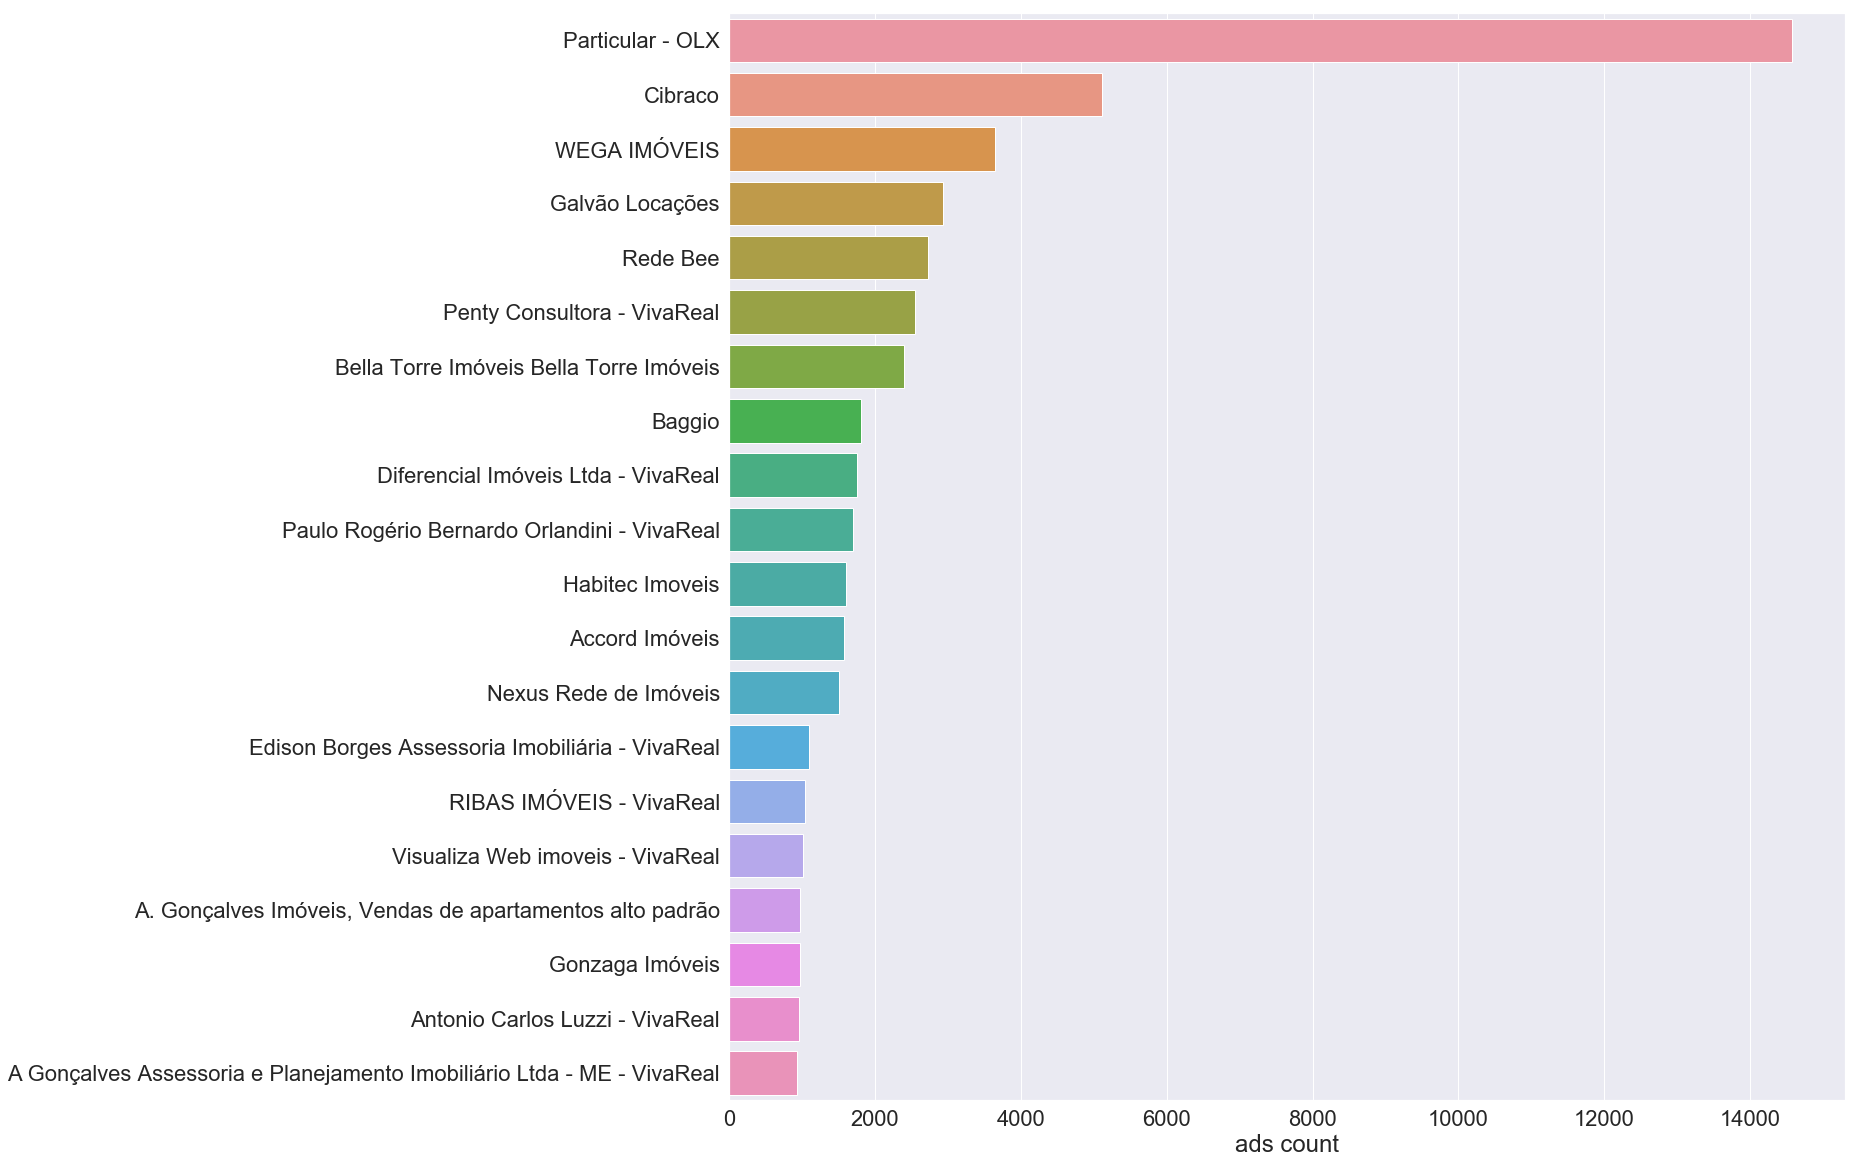

In [49]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=2)
ax = sns.barplot(y=top_ads.index[:20], x=top_ads.head(20))
ax.set(xlabel='ads count')

In [89]:
## Popular Advertiser
top_ads.index[top_ads.values > 50].shape

(475,)

In [90]:
## Third Company
top_ads.index[top_ads.values <= 50].shape

(1107,)

In [157]:
df_selected.isnull().sum()

advertiser.id            1591
advertiser.name          1591
area_total              43776
area_util               28606
neighborhood.id          1148
neighborhood.name        1148
bathroom                38243
city.full_name              0
city.short_name             0
city_uf                     0
code                    84922
condominium             40432
date_inclusion              0
default                     0
description                 0
address                 30348
error                       0
goal                        0
garage                  21169
geohash                 30375
geometry.coordinates    30375
geometry.type           30375
iptu                    53726
isparticular                0
isportal                    0
latitude                30336
photolist                4461
longitude               30336
optional                    0
bedroom                 13090
scraping.spider_name        0
status                      0
suite                   54175
motion_typ

In [163]:
df_ddp = df_selected.drop_duplicates(['title'], keep='first')

In [164]:
print(df_selected[df_selected.duplicated(['title'], keep='first')].shape)

(57721, 42)


In [224]:
df_selected.shape

(149968, 42)

In [223]:
df_ddp.shape

(92247, 43)

In [225]:
df_wo.shape

(86164, 43)

# Deal with outlier

1. What typeso f interesting outliers can be idetified?
    - What rule should we use to remove or maintain outlier? -> See distibution with z-score

In [165]:
df_ddp['z_value'] = np.abs((df_ddp['value'] - df_ddp['value'].mean())/df_ddp['value'].std(ddof=0))

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [166]:
df_wo = df_ddp[df_ddp['z_value'] < 1]

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

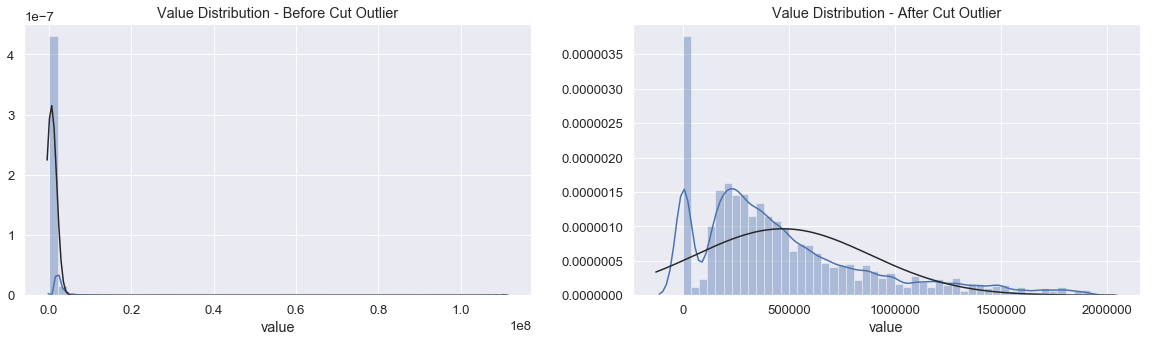

In [221]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.distplot(df_ddp['value'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Before Cut Outlier")
sns.distplot(df_wo['value'], fit=norm, ax=ax[1]).set_title("Value Distribution - After Cut Outlier")

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

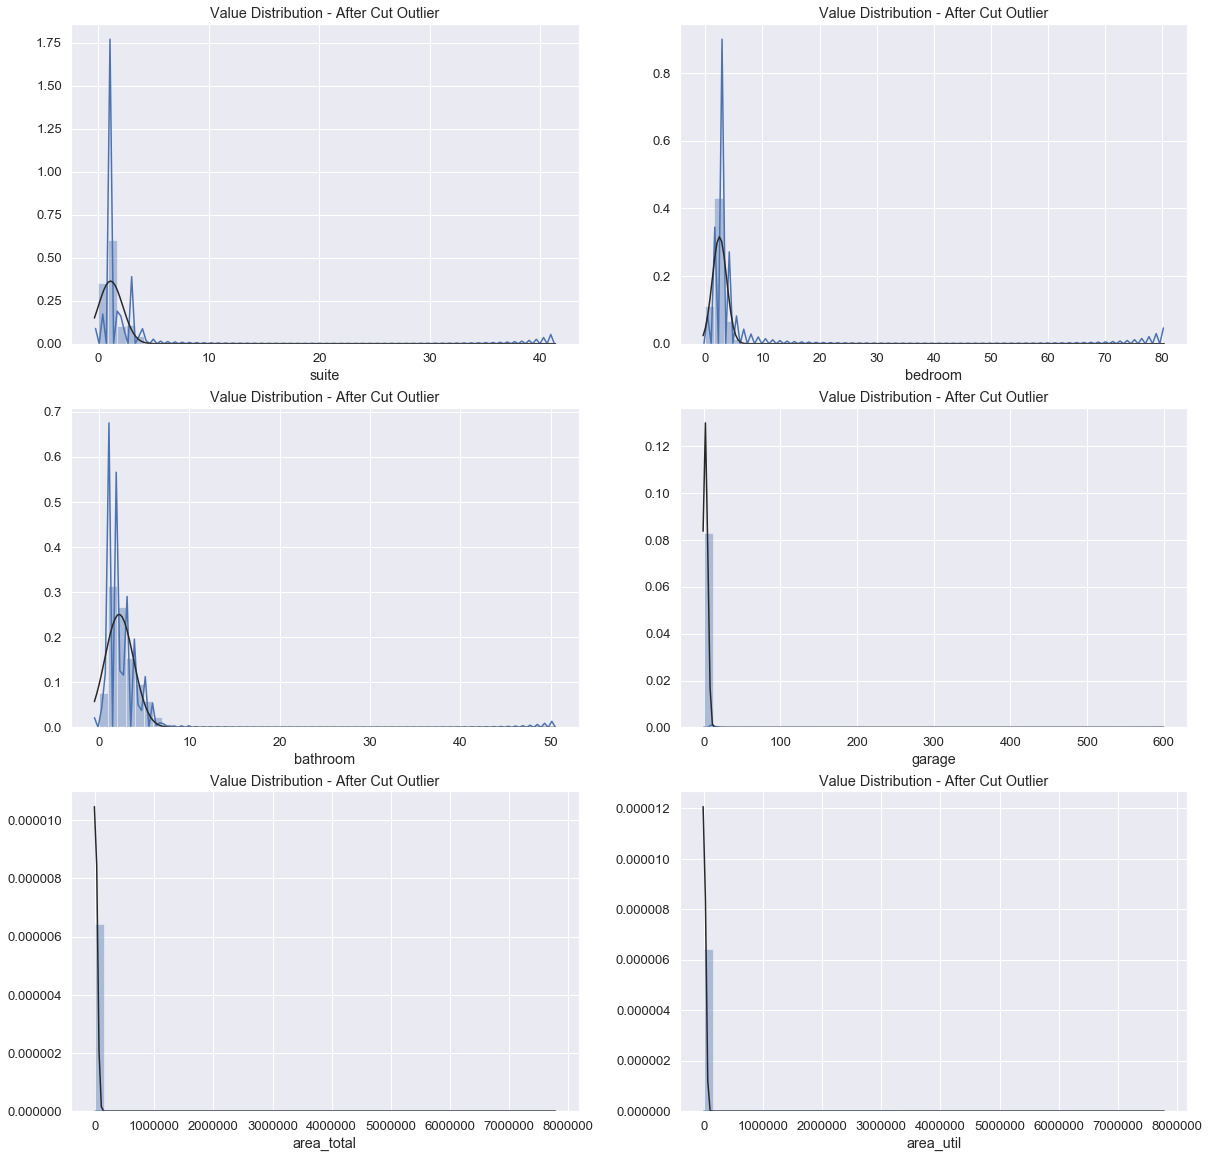

In [214]:
fig, ax = plt.subplots(3,2, figsize=(20, 20))
sns.distplot(df_ddp['suite'].dropna(), fit=norm, ax=ax[0][0]).set_title("Value Distribution - After Cut Outlier") 
sns.distplot(df_ddp['bedroom'].dropna(), fit=norm, ax=ax[0][1]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_ddp['bathroom'].dropna(), fit=norm, ax=ax[1][0]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_ddp['garage'].dropna(), fit=norm, ax=ax[1][1]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_ddp['area_total'].dropna(), fit=norm, ax=ax[2][0]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_ddp['area_util'].dropna(), fit=norm, ax=ax[2][1]).set_title("Value Distribution - After Cut Outlier")

In [234]:
df_wo.shape

(86164, 43)

In [254]:
df_wo.isnull().sum()

advertiser.id             573
advertiser.name           573
area_total              32985
area_util               22064
neighborhood.id           581
neighborhood.name         581
bathroom                25540
city.full_name              0
city.short_name             0
city_uf                     0
code                    42344
condominium             23101
date_inclusion              0
default                     0
description                 0
address                 22462
error                       0
goal                        0
garage                  10038
geohash                 22462
geometry.coordinates    22462
geometry.type           22462
iptu                    33592
isparticular                0
isportal                    0
latitude                22450
photolist                1705
longitude               22450
optional                    0
bedroom                  5492
scraping.spider_name        0
status                      0
suite                   34176
motion_typ

In [250]:
df_wo['motion_type'].apply(' ,'.join)

0                            Casa
1                         Sobrado
3                     Apartamento
4                            Casa
5                 Quarto ,Sobrado
6                      Residencia
7             Terreno ,Residencia
8                            Casa
9                            Casa
10                    Apartamento
11        Apartamento ,Residencia
12        Apartamento ,Residencia
13                       Conjunto
14        Apartamento ,Residencia
15                    Apartamento
16                        Sobrado
17                           Casa
18           Garagem ,Apartamento
19                    Apartamento
20                           Casa
21                           Loja
22                   Quarto ,Casa
23                        Sobrado
26                           Casa
27                           Casa
28                   Quarto ,Casa
30                      Cobertura
31                     Residencia
32                         Quarto
33            

Text(0.5, 1.0, 'Value Distribution - Before Cut Outlier')

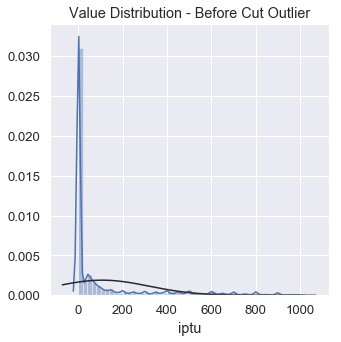

In [248]:
plt.figure(figsize=(5 , 5))
sns.distplot(df_wo['iptu'][df_wo['iptu'] < 1000].dropna(), fit=norm).set_title("Value Distribution - Before Cut Outlier")

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

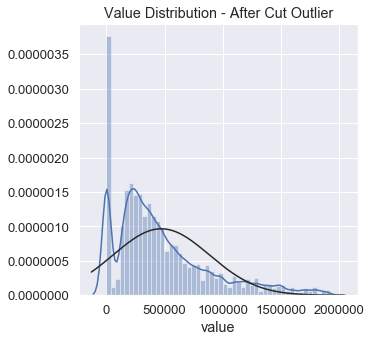

In [181]:
## Plot Value Distribution
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)
sns.distplot(df_wo['value'], fit=norm).set_title("Value Distribution - After Cut Outlier")

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

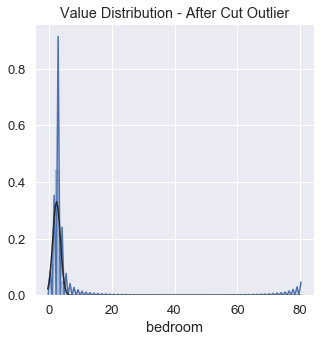

In [187]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)
sns.distplot(df_wo['bedroom'].dropna(), fit=norm).set_title("Value Distribution - After Cut Outlier")

In [36]:
df_wo[df_wo['value'] <= 500000]['value'].count()

63504

In [62]:
df_wo['motion_type'].apply(', '.join)

0                            Casa
1                         Sobrado
3                     Apartamento
4                            Casa
5                 Quarto, Sobrado
6                      Residencia
7             Terreno, Residencia
8                            Casa
9                            Casa
10                    Apartamento
11        Apartamento, Residencia
12        Apartamento, Residencia
13                       Conjunto
14        Apartamento, Residencia
15                    Apartamento
16                        Sobrado
17                           Casa
18           Garagem, Apartamento
19                    Apartamento
20                           Casa
21                           Loja
22                   Quarto, Casa
23                        Sobrado
25                    Apartamento
26                           Casa
27                           Casa
28                   Quarto, Casa
29                    Apartamento
30                      Cobertura
31            

# Value Analysis

### Beware! Business Type

In [134]:
## Sell
df_selected[df_selected['business_type'] == 'Venda']['value'].describe()

count    1.229670e+05
mean     7.415702e+05
std      1.261271e+06
min      1.000000e+04
25%      2.690000e+05
50%      4.500000e+05
75%      8.001180e+05
max      1.111111e+08
Name: value, dtype: float64

In [135]:
## Rent
df_selected[df_selected['business_type'] == 'Locação']['value'].describe()

count    25539.000000
mean      2841.348977
std       5538.248599
min        100.000000
25%        800.000000
50%       1210.000000
75%       2400.000000
max      98000.000000
Name: value, dtype: float64

In [ ]:
print([f for f in df_wo['neighborhood.name'].unique()])

In [ ]:
df_wo['neighborhood.name']

## Top 20 High price neighborhood

In [ ]:
top_mean_price = df_wo[['neighborhood.name', 'value']].groupby(['neighborhood.name'], as_index=False).mean()

In [ ]:
top_mean_price.sort_values(by=('value'), ascending=False).head(20)

top_mean_price.sort_values(by=('value'), ascending=False).head(20)

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x="value", y="neighborhood.name", data=top_mean_price.sort_values(by=('value'), ascending=False).head(20))

## Map of the Top 20 High Price neighborhood

## Distribution Top 10 price neighborhood

In [ ]:
## top price neighborhood name ##
top_10_name = top_mean_price.sort_values(by=('value'), ascending=False).head(10)['neighborhood.name'].unique()

In [ ]:
list(top_10_name)

In [ ]:
df_top10_dist = df_wo[df_wo['neighborhood.name'].isin(top_10_name)]

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_top10_dist, x="value", y="neighborhood.name")

## Bedrooms and Price Analysis

### Cleaning Bedrooms

In [ ]:
df_wo[['bedroom']]

In [ ]:
bedroom_price = df_wo[['bedroom', 'value']].groupby(['bedroom'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="bedroom", y="value", data=bedroom_price.sort_values(by=('value'), ascending=False).head(30))

In [ ]:
## Notes ##
# have outlier in bedrooms

## Garage and Price Analysis

In [ ]:
garage_price = df_wo[['garage', 'value']].groupby(['garage'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="garage", y="value", data=garage_price.sort_values(by=('value'), ascending=False).head(30))

## Bathroom and Price Analysis

In [ ]:
bathroom_price = df_wo[['bathroom', 'value']].groupby(['bathroom'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="bathroom", y="value", data=bathroom_price.sort_values(by=('value'), ascending=False).head(30))

## Suite and Price Analysis

In [ ]:
suite_price = df_wo[['suite', 'value']].groupby(['suite'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="suite", y="value", data=suite_price.sort_values(by=('value'), ascending=False).head(30))

## Area and Price Analysis

In [ ]:
area_total_price = df_wo[['area_total', 'value']].groupby(['area_total'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="area_total", y="value", data=area_total_price.sort_values(by=('value'), ascending=False).head(20))

### Number
area_total -
area_util -
bathroom -
garage -
bedroom -
suite

In [ ]:
df_est_prop = df_wo[['value','area_total', 'area_util', 'bathroom', 'garage', 'bedroom', 'suite']]

In [ ]:
df_est_prop_corr = df_est_prop.corr()

In [ ]:
plt.figure(figsize=(10, 10))
pp = sns.heatmap(df_est_prop_corr, linewidths=.2, cmap="YlGnBu", annot = True)